# Assign 4: Model Selection

In this lab you will not only train several models, but you'll look at the process needed to answer one of the most important (and difficult) questions, which is:
* "_**How good will this model be at making future predictions**_?"

To answer this question we'll look back at some performance metrics we have seen, and also talk about model underfitting/overfitting and the bias-variance tradeoff. These latter two concepts are general and can be difficult to articulate, but are really important in the world of ML. They also often show up in job interviews for Data Science and/or Machine Learning, so it's important that you understand them well enough to be able to describe/explain what they are to someone else. Although this is succintly referred to as "_Model Selection_", we can also think of this as trying better understand a model's future prediction accuracy. 

*Note that this notebook uses the [Ames, Iowa housing dataset](https://jse.amstat.org/v19n3/decock.pdf), which was featured in the [Kaggle](https://www.kaggle.com/) [Housing Prices Competition](https://www.kaggle.com/competitions/home-data-for-ml-course).*


To start, we'll load the Python modules to be used in the lab. If you recall in the last lab, we loaded each module just before it was used, but tha was only for us to see which modules were used for what. This approach of loading them all at the beginning is the typical practice of anyone creating a Jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis (EDA)

It cannot be stated enough, but getting acquainted with your data before beginning any analysis or modeling task is critical. If you don't, you could easily spend a lot of time attempting to fit a certain type of model to your data, only to later find out that there is something about the data that would have made you choose a different approach. 

Let's now quickly open the file and use `df.describe()` to see what it looks like. The response or target variable that we will be modeling is `SalePrice`, which is the very last column in the data (so scroll all the way to the right to see what this variable looks like).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sgeinitz/CS3120/refs/heads/main/lab2_data_ames_housing.csv')
print(f"** df has {df.shape[0]} rows and {df.shape[1]} columns **")
df.describe()

** df has 1460 rows and 81 columns **


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The other important first step is to see a few rows of the raw data itself using `df.head()`. )

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


With so many columns it can be hard to get an idea of which features there are, let alone understand how they are distributed. One other pandas method that can be useful to better understand how discrete features are distributed is `groupby`. 

Here is an example of using `groupby` to see how many houses fall into each category of `MSZoning`. 

In [4]:
df.groupby('Street').size()

Street
Grvl       6
Pave    1454
dtype: int64

From that we can see that there are 6 houses on a gravel road while all of the others are on a paved road. 

We could also look at the mean price of the outcome, `SalePrice`, for these different categories. If the means are quite different, than this might be a good indication that houses on gravel roads are simply different types of houses (and thus have lower or higher prices). 

In [5]:
# use group by on MSZoning to get the mean of SalePrice
df.groupby('Street')['SalePrice'].mean()

Street
Grvl    130190.500000
Pave    181130.538514
Name: SalePrice, dtype: float64

***
### Q1: Use `groupby` on the feature, `BedroomAbvGr`, to see how many houses have 1 bedroom, 2 bedrooms, etc.***
1. ***What seems to be the average, or most typical number of bedrooms a home has?*** 
2. ***How many houses in this dataset have this number of bedrooms?***

1. The most typical number of bedrooms a home has is 3
2. In this dataset, there are 804 homes with 3 bedrooms
***

In [6]:
df.groupby('BedroomAbvGr').size()

BedroomAbvGr
0      6
1     50
2    358
3    804
4    213
5     21
6      7
8      1
dtype: int64

We won't do it here, but plotting each feature individually, and plotting it against the response or target variable, is another helpful way to understand what is happening with the data. However, it can also be quite time consuming. 

There are now tools to help automate some of this. The first we'll mention is the VS Code extension, [Data Wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler). This allows you to quickly look at the data and see what the distribution of each column looks like, see how may missing values each column has, how many distinct values, etc.

If we wanted to use a tool that only depended on Python (and was not an IDE extension), then there are other options. 
The Python module, [YData-Profiling (formerly Pandas Profiling)](https://github.com/ydataai/ydata-profiling), even goes beyond what Data Wrangler does. Here is an [example of this EDA tool on the Titanic dataset](https://docs.profiling.ydata.ai/latest/examples/titanic/titanic_report.html). You should definitly consider using this type of tool for your course project in this class. 

Before we continue let's pick out a subset of columns that we'll use to model. In other words, wwe won't use all of the features right away, but we'll instead just use the numeric features, and perhaps one categorical feature. 

In [7]:
# get a list of the column names that are either integers or floats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics).copy()
numeric_df.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
# Get the column, Neighborhood from df and convert it to a one-hot encoded DataFrame
neighborhood = df['Neighborhood']
neighborhood = pd.get_dummies(neighborhood).astype(int)
neighborhood.shape

# Add the one-hot encoded DataFrame to numeric_df
numeric_df = pd.concat([numeric_df, neighborhood], axis=1)
numeric_df.shape

(1460, 63)

Of all of those 38 columns, which includes the outcome, SalesPrice, let's see which ones have missing values. We could manually look at this with Data Wrangler, but the following code cell quickly checks how many missing values each column has. 

Note that dealing with missing values is an entire subject on its own. We will touch on it a little more, but you would likely see more about it in an advanced Statistics or ML course. To give you a peek of what it entails, check out this reference on [Dealing with Missing Data](https://www.dasca.org/world-of-data-science/article/strategies-for-handling-missing-values-in-data-analysis). 


Since we are not going to deal with missing values directly (by trying to replace the missing values with a 'best guess'), we will simply exclude columns that have _too many_ missing values. Exactly how many is _too many_ is up to us, but we'll opt for a max of 50. 

In [9]:
# See which columns in numeric_df have more than 50 missing values
missing = numeric_df.isnull().sum()
missing = missing[missing > 50]
print(missing)

# Remove these columns from the DataFrame
ncols_before = numeric_df.shape[1]
numeric_df = numeric_df.drop(columns=missing.index)
ncols_after = numeric_df.shape[1]
print(f"** Removed {ncols_before - ncols_after} columns **")

LotFrontage    259
GarageYrBlt     81
dtype: int64
** Removed 2 columns **


We'll now remove the rows from the data that have any missing values. Again, you may deal with missing values in a different way depending on how much data you have, which column it is that has missing values, etc. But, for us, we'll simply remove the rows with missing data. 

In [10]:
# Remove rows with missing values
nrows_before = numeric_df.shape[0]
numeric_df = numeric_df.dropna()
nrows_after = numeric_df.shape[0]
print(f"** Removed {nrows_before - nrows_after} rows **")
numeric_df.shape

** Removed 8 rows **


(1452, 61)

We'll now copy over the predictors (or features, or independent variables) to a __Pandas Data Frame__, `X`, and the outcome (or response, or dependent variable, target variable, etc.) to a __Pandas Data Series__, `y`. 

In [11]:
X = numeric_df.drop(columns=['Id','SalePrice']).copy() # remove the index Id and outcome SalePrice
y = numeric_df['SalePrice'].copy()


***
### Q2: What is the `shape` of X and y? In the following code cell input the code needed to see the shape of X and y. Then for your answer here state the number of rows and columns in each X and y. 

X has 1452 rows and 84 columns. y is a single column with 1452 rows.
***

In [12]:
# output the shape of X and y here
print(X.shape)
print(y.shape)

(1452, 59)
(1452,)


Next we'll add a few more features to our data. Note that these are not entirely new features, but features that are transformations of the current features in some way. We're not going into much detail here, but there is also a lot that can be said about the practice of _[Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)_, which is where you take the features you have and manipulate/combined/transform them in some way to create new features that (ideally) are able to predict y even better than the original features. 

In [13]:
# Add columns to X for square root of 1stFlrSF, LotArea, GrLivArea, WoodDeckSF, OpenPorchSF, GarageArea
X['sqrt_1stFlrSF'] = np.sqrt(X['1stFlrSF'])
X['sqrt_LotArea'] = np.sqrt(X['LotArea'])
X['sqrt_GrLivArea'] = np.sqrt(X['GrLivArea'])
X['sqrt_WoodDeckSF'] = np.sqrt(X['WoodDeckSF'])
X['sqrt_OpenPorchSF'] = np.sqrt(X['OpenPorchSF'])
X['sqrt_GarageArea'] = np.sqrt(X['GarageArea'])
X.shape

# Add columns to X for the quadratic of 1stFlrSF, LotArea, GrLivArea, WoodDeckSF, OpenPorchSF, GarageArea
X['quad_1stFlrSF'] = X['1stFlrSF']**2
X['quad_LotArea'] = X['LotArea']**2
X['quad_GrLivArea'] = X['GrLivArea']**2
X['quad_WoodDeckSF'] = X['WoodDeckSF']**2
X['quad_OpenPorchSF'] = X['OpenPorchSF']**2
X['quad_GarageArea'] = X['GarageArea']**2
X.shape

(1452, 71)

Let's now sort the columns of `X`, i.e. the features, so that the first column is the one with the highest correlation with `y`, the second column has the second highest correlation with `y`, and so on. 

In [14]:
# Sort the columns of X according to how strong their correlation is with SalePrice
correlations = X.corrwith(y).abs().sort_values(ascending=False)
X = X[correlations.index]
X.head()

,OverallQual,GrLivArea,sqrt_GrLivArea,quad_GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,sqrt_1stFlrSF,quad_GarageArea,...,Gilbert,YrSold,LowQualFinSF,NWAmes,MiscVal,Blueste,Blmngtn,BsmtHalfBath,SawyerW,BsmtFinSF2
0,7,1710,41.352146,2924100,2,548,856,856,29.257478,300304,...,0,2008,0,0,0,0,0,0,0,0
1,6,1262,35.524639,1592644,2,460,1262,1262,35.524639,211600,...,0,2007,0,0,0,0,0,1,0,0
2,7,1786,42.261093,3189796,2,608,920,920,30.331502,369664,...,0,2008,0,0,0,0,0,0,0,0
3,7,1717,41.436699,2948089,3,642,756,961,31.000000,412164,...,0,2006,0,0,0,0,0,0,0,0
4,8,2198,46.882833,4831204,3,836,1145,1145,33.837849,698896,...,0,2008,0,0,0,0,0,0,0,0


***
### Q3: Does the feature engineering step seem like it was a good idea for this dataset of Home Sale Prices? Answer yes or no, and explain why.

I would argue the feature engineering step for this dataset was a good idea because in this particular case, for 'GrLivArea' and both of its transformations, they all ranked the highest (except for 'OverallQual') among all the features. Because of this, it is very clear that 'GrLivArea' is indeed a crucial predictor for the sales price of a home, no matter how it is scaled.
***

## Model Tuning

Let's now try a few different types of models and try to "_tune_~ each one. When we say "_tune_" a model, what we mean is that we want to find the ideal value of the model's [hyperparameter(s)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Remember that a `hyperparameter` is a parameter of a model that is not fit/learned directly from the data. Rather, it is a value that determines _how the model will learn_ from the. Some examples are:
* `max_depth` of a Decision Tree - the maximum depth of a decision tree is not directly learned from the data, but it will affect how the model learns, and ultimately how many parameters will be in the tree
* `num_estimators` in an Ensemble model (e.g. Random Forest or GradientBoosting Tree) - again, this will affect how many total parameters will be in the final (ensemble) model

Note that there are often times more than one hyperparameter. Below we are trying many values of a hyperparameter, e.g. $n_{h1}$ possible values. However, if there were multiple hyperparameters and the second one had $n_{h2}$ possible values, and the third had $n_{h3}$, ..., and the $k^{th}$ had $n_{hk}$ possible values, then there would be an a huge number of possible combinations that we would need to consider (namely, $n_{h1}\cdot n_{h2}\cdot \dots \cdot n_{hk}$). Fortunately, most models do not have too many hyperparameters to consider, or perhaps not many values of each to consider, so in practice this is typically not too onerous. But, be careful about trying to tune a model for every possible hyperparameter. 

Before we begin to do any model training, remember that it is critical that we split the data into separate training and test datasets. 

Note that code below is splitting the data into 80% training data and 20% test data. This is the typical split although there may be times where a different proportion would make more sense. 

In [15]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### Least Squares Regression Model

We'll now fit a basic Least Squares regression model to this data. 

In [16]:
# Fit a regression model to the data using only the first column of X to predict y
model_ls = LinearRegression()
num_features = X.shape[1]

rmse_values_ls = []
pred_rmse_values_ls = []
min_features = 1
for i in range(min_features, num_features + 1):
    model_ls.fit(X_train.iloc[:,0:i], y_train)
    mse = np.sqrt(np.mean((y_train - model_ls.predict(X_train.iloc[:,0:i]))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_ls.predict(X_test.iloc[:,0:i]))**2))
    rmse_values_ls.append(mse)
    pred_rmse_values_ls.append(pred_mse)

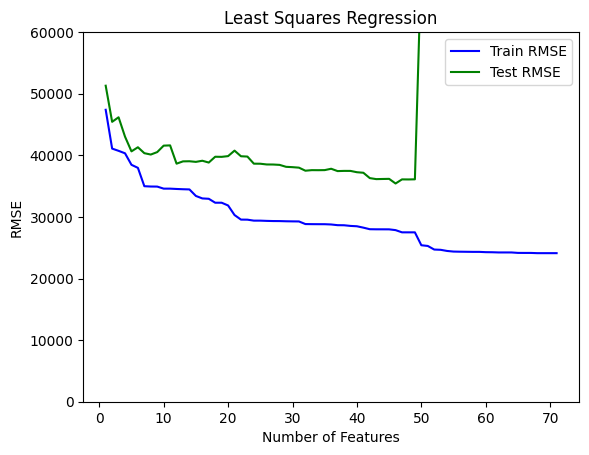

In [17]:
# Plot the rmse values
plt.plot(range(min_features, num_features + 1), rmse_values_ls, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), pred_rmse_values_ls, label='Test RMSE', color='green')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.ylim(0, 60000)
plt.title('Least Squares Regression')
plt.legend()
plt.show()

In [18]:
rmse_values_dt = []
pred_rmse_values_dt = []
max_depths = range(1, 50)
for i in range(len(max_depths)):
    model_dt = DecisionTreeRegressor(max_depth=max_depths[i])
    model_dt.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_dt.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_dt.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

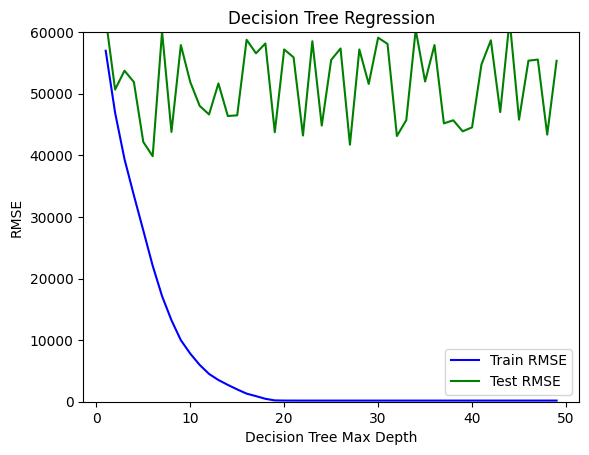

In [19]:
# Plot the rmse values
plt.plot(range(min(max_depths), max(max_depths)+1), rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(range(min(max_depths), max(max_depths)+1), pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Regression')
plt.ylim(0, 60000)
plt.legend()
plt.show()

In [20]:
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 102, 5))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_rf = RandomForestRegressor(n_estimators=poss_num_estimators[i], min_samples_leaf=1, random_state=2)
    model_rf.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_rf.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_rf.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

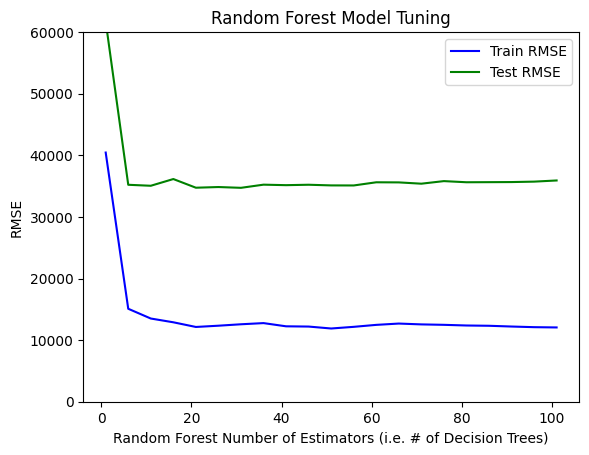

In [21]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Random Forest Number of Estimators (i.e. # of Decision Trees)')
plt.ylabel('RMSE')
plt.title('Random Forest Model Tuning')
plt.ylim(0, 60000)
plt.legend()
plt.show()

In [22]:
# Let's try a Gradient Boosting Regressor
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 402, 10))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_gb = GradientBoostingRegressor(n_estimators=poss_num_estimators[i], learning_rate=0.1, random_state=2)
    model_gb.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_gb.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_gb.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

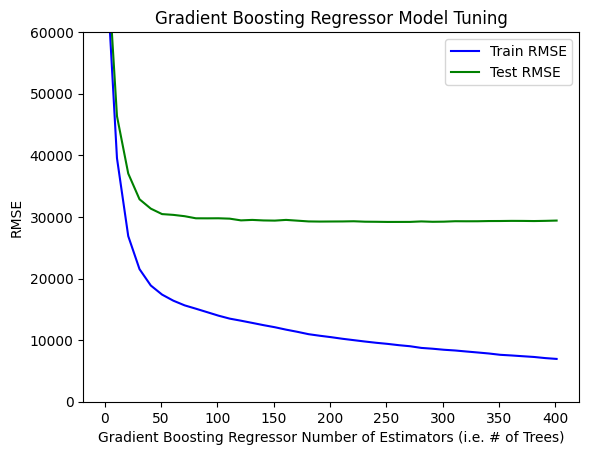

In [23]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Gradient Boosting Regressor Number of Estimators (i.e. # of Trees)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Regressor Model Tuning')
plt.ylim(0, 60000)
plt.legend()
plt.show()

***
### Q4: Based on the results above, which model would you choose, and which hyperparameter value for that model would you use? Explain your answer. 

Of the four models presented above, I would choose the gradient boosting regressor. After getting a sufficient amount of estimators, it has the lowest test RMSE value of about 30,000. The other models have a higher value than this, with the worst one being the decision tree averaging at about 50,000 for its RMSE value. The hyperparameter value for the gradient boosting regressor model I would choose would be about 50 estimators/trees. When looking at the graph presented directly above, its  clear that anything more than 50 has very marginal improvements, and would also likely lead to overfitting.
***

## Estimating a Model's Future Accuracy

From the above we might have a decent idea of how well a model will perform on future data. After all, we did have separate `train` and `test` datasets, so it seems like we can confidently say what the accuracy will be on future data. 

However, we have to remember that our `test` dataset is just one possible example of future data that our model might encounter. We know that the accuracy on a different _future_ dataset will not be the exact same as the accuracy we saw above on the test dataset. Therefore, what we really need to do is to _estimate_ what our model's future accuracy will be. Which means that we have to get an idea of how much the accuracy (or RMSE) will vary from one _test_ dataset to another. As you know from basic Statistics, this sounds a lot like trying to undestand the variance of the model's performance metric for all possible future test datasets. 

But, where can we get more test data? We need training data, and ideally the more training data the better. So, we can't simply just change the training/test split from, say, 80/20, to be 50/50 or 20/80. 
What can we do? This is where the idea of **[Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))** comes into play. Let's now use Scikit Learn's `cross_val_score` function to split our data one time into one possible training and test split; then do it again with a different training and test split; then again, up to $k$ possible times. This is called **K-fold Cross-validation** and it gives us **k** different test datasets of size $\frac{1}{k}\cdot n$, where $n$ is the size of our original dataset. 


In [24]:
# set k to be the number of folds for cross-validation (i.e. the number of different test dataset we'll use)
k = 10

In [25]:
model_ls = LinearRegression()
scores_ls = cross_val_score(model_ls, X.iloc[:,:30], y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_ls.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_ls.var()):1.2E} **")

** Average R2 = 8.21E-01 **
** R2 SD = 6.93E-02 **


In [26]:
model_dt = DecisionTreeRegressor(max_depth=20, random_state=2)
scores_dt = cross_val_score(model_dt, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_dt.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_dt.var()):1.2E} **")

** Average R2 = 7.26E-01 **
** R2 SD = 1.00E-01 **


In [27]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=2)
scores_rf = cross_val_score(model_rf, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_rf.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_rf.var()):1.2E} **")

** Average R2 = 8.56E-01 **
** R2 SD = 4.96E-02 **


In [28]:
model_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=2)
scores_gb = cross_val_score(model_gb, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_gb.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_gb.var()):1.2E} **")

** Average R2 = 8.87E-01 **
** R2 SD = 3.64E-02 **


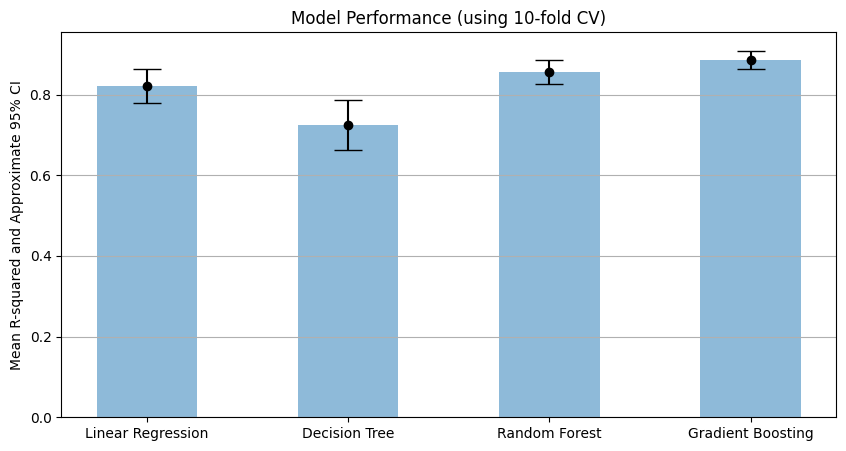

In [29]:
# plot score means and variances on a bar chart with a line for the variance
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
means = [scores_ls.mean(), scores_dt.mean(), scores_rf.mean(), scores_gb.mean()]
stderrors = [scores_ls.std(), scores_dt.std(), scores_rf.std(), scores_gb.std()] / np.sqrt(k)

fig, ax = plt.subplots(figsize=(10, 5))
#ax.bar(models, means, yerr=variances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(models, means, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.5)
ax.errorbar(models, means, yerr=1.96*stderrors, fmt='o', color='black', ecolor='black', capsize=10)
ax.set_ylabel(f'Mean R-squared and Approximate 95% CI')
ax.set_title(f'Model Performance (using {k}-fold CV)')
ax.yaxis.grid(True)
plt.show()

Although we have a relatively small sample size to estimate $R^2$ (in this case, k, the number of folds) we can still use the typical approach to point estimation and standard errors to get an idea of what the 95% confidence interval is. The above plot shows the mean $R^2$ and approximate confidence intervals. Confirming what we suspected before, it does seem that the Gradient Boosting Tree(s) is the best choice. 

### Thorough Model Tuning
As you can imagine, just eyeballing the best hyperparameter value for a model based on curves like the ones we plotted above is not the most scientific. Oftentimes, once we have selected a model, we will want to try several different hyperparameter values, and perhaps combinations of the various hyperparameters associated with a model. 

For Gradient Boosting there are two important hyperparameters: 
* num_estimators - number of trees (linked together sequentially)
* learning_rate - the amount of importance/weight each successive tree will decrease by

We'll now use `GridSearch Cross-validation` to find the best values of these hyperparameters in a more robust way than we did earlier. 

In [30]:
# Okay, use grid search to find the best hyperparameters for the Gradient Boosting Regressor
param_grid = {
    'n_estimators': list(range(1, 402, 50)),
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]
}

model_gb = GradientBoostingRegressor(random_state=2)
grid_search = GridSearchCV(model_gb, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print(f"** Best R2 = {grid_search.best_score_:1.2E} **")
print(f"** Best Parameters = {grid_search.best_params_} **")

** Best R2 = 8.90E-01 **
** Best Parameters = {'learning_rate': 0.05, 'n_estimators': 401} **


It looks like a learning rate of 0.05 and ~400 trees will give us the best possible model. Let's now plot all the $R^2$ values for each combination of hyperparameter values that were tried. 

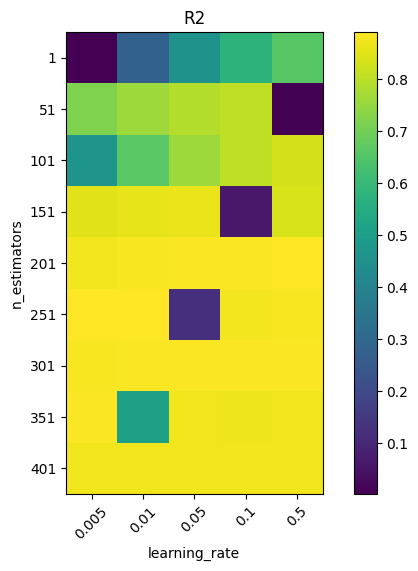

In [31]:
# plot a heatmap of the R2 values for the different hyperparameters
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['n_estimators']), len(param_grid['learning_rate']))

plt.figure(figsize=(8, 6))
plt.imshow(scores, cmap='viridis')
#plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['learning_rate'])), param_grid['learning_rate'], rotation=45)
plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.title('R2')
plt.show()

***
### Q5: You should now have a good level of understanding of selecting and tuning a model. For this last question, go ahead and try out a new model type of your choice. Do **not** use one of the models above, but instead select one from the list below. Once you've done that, go ahead and run `grid search cross-validation` on the model and see if you can find one that fits the data better than the Gradient Boosting Tree above. The qustion is then, what is the peformance of your model? (i.e. what is the $R^2$?) 

\<INPUT YOUR ANSWER TO Q5 HERE - i.e. what model did you choose and what was the $R^2$?\>
***

Here is a list of models that we have not explicitly talked about in class (although most are specialized versions of linear models or boosting ensemble models):

* [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)
* [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
* [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) - we looked at K-nearest neighbors, so this might be a good one to try, remember what the hyperparameter $k$ does when it comes to increasing/decreasing model complexity
* [Linear Models with automatica Variable Selection](https://scikit-learn.org/stable/api/sklearn.linear_model.html#regressors-with-variable-selection) - we won't cover these much, but this is something you would discuss in a Statistical Methods course, or other course on traditional statistical modeling methods
* [Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - we haven't yet talked about Support Vector Machines but you can still use it here if you want to experiment

In [35]:
# import the new model you have chosen
from sklearn.neighbors import NearestNeighbors

# declare an instance of your model
model_kneighbors = NearestNeighbors(n_neighbors=2)

In [ ]:
# set up a grid or range of hyperparameter values to search over
param_grid = {

}

In [ ]:
# use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model_kneighbors, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print(f"** Best R2 = {grid_search.best_score_:1.2E} **")
print(f"** Best Parameters = {grid_search.best_params_} **")

Note that if you want to do a little bit extra to make your model even better, you could try one (or both) of the following:
1. Add some of the categorical features that were left out earlier, which you'll likely need to encode the same way we did above with `Neighborhood`
2. Do some more feature engineering to create new features from the existing ones (e.g. interactions, new categorical variables based on old ones, etc.)